# Interpolating the Libor rate

<a href="https://juanfonsecasolis.github.io/">Juan M. Fonseca-Solís</a> · March 2015 (last updated on June 2025) · 7 min read

---

# Summary

In this _ipython notebook_ we'll study signal interpolation, a tool that allows you to approximate the value of data that wasn't taken during the measurement process. Interpolation typically uses a regular sampling rate and symmetric kernels, but we want to study the case of data taken at irregular sampling rates, like the London interbank interest rate (LIBOR), offered monthly by the Central Bank of Costa Rica (BCCR) at four maturity levels (months). Previous authors have proposed a technique called rate-of-innovation (RoI), but we want to use asymmetric kernels. The results showed that our technique is valid.

# Interpolating LIBOR rate manually

The _London InterBank Offered Rate_ (known for short as LIBOR) was a daily reference rate published by Barclays, a British international bank [4], to determine the interest rate of loans (money borrowing) in foreign currencies [3,4]. It consists of a set of four maturity levels (the time until the loan will be charged) for one, three, six or twelve months. Due to a scandal and a legal dispute held in 2012 by the _Commodity Futures Negotiation Commission of the United States (CFTC)_ the LIBOR rate is not used anymore [3,4], but it can help us to explain how linear interpolation works using the convolution of samples with symmetric kernels. 

![](../img/libor-scandal-headlines-the-financial-times-newspaper-london-august-CTX670.jpg)
![](../img/article-2172377-140736A7000005DC-647_634x422.jpg)

Interpolation means approximating an unknown value between two provided (sampled) data points. In the case of LIBOR, this is calculated manually using the linear formula below [5]:

$$
y_n = \frac{y_1-y_0}{x_1-x_0} (x_n-x_0) + y_0 \quad (1).
$$


The Libor interest rates at eight months is, for instance, 3.5:

The Libor rate for 8 month(s) is 3.5.


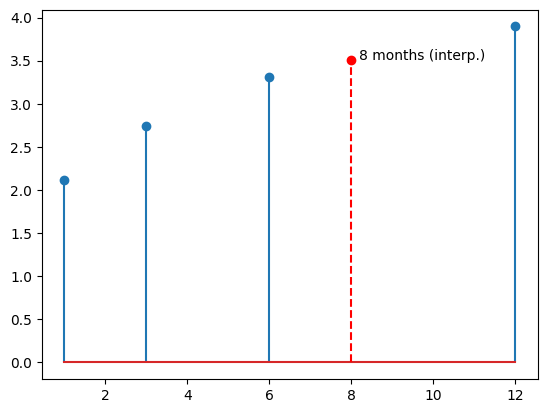

In [1]:
import matplotlib.pylab as plt
import numpy as np

x = [1, 3, 6, 12]
y = [2.12029, 2.73757, 3.31129, 3.89643]

plt.stem(x, y)
x_n = 8
y_n = (y[3]-y[2])/(x[3]-x[2]) * (x_n - x[2]) + y[2]
plt.stem(x_n, y_n, '--ro')
plt.annotate(f'{x_n} months (interp.)', [x_n+0.2, y_n])
print(f'The Libor rate for {x_n} month(s) is {np.round(y_n, 1)}.')

Although this formula works, it doesn't give you the flexibility of applying other types of interpolation (for instance, polynomic interpolation) without re-defining the equation. So, is there a way to perform interpolation using a generic method?

# Interpolation kernels

The answer is yes, and for explaining the reason we need to introduce a mathematical animal called _interpolation kernel_, denoted by $I[n]$. When the interpolation kernel is [convolved](https://en.wikipedia.org/wiki/Convolution) with each sample available, the sum of all convolutions provides the interpolated function, denoted by $\tilde{x}[n]$, as follows [2]: 

$$
    \tilde{x}[n] = \{x*I\}[n] = \sum_{k=-\infty}^{\infty}{x[k]I \left[ \frac{n-kT}{T} \right] }  \quad (2),
$$

where $T$ is the sampling period (in samples). 

# Interpolation using a fixed sampling rate

Before jumping into the LIBOR rate, let's study how signals are interpolated using a fixed sampling rate, using kernels:

Discrete frequency: 0.1 samples per second.


<StemContainer object of 3 artists>

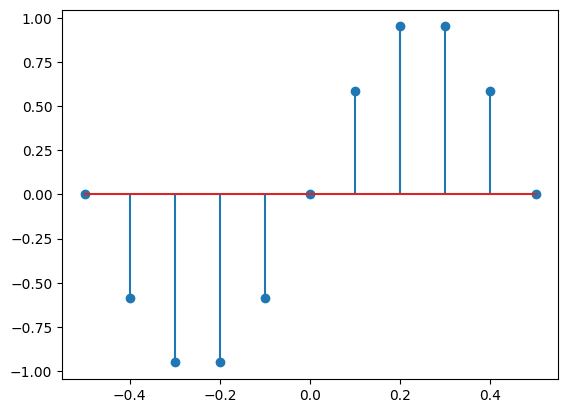

In [2]:
Fs = 10.0 # Hz
F0 = 1.0 # Hz
print(f'Discrete frequency: {F0/Fs} samples per second.')
x = np.arange(-5, 6)/Fs # two periods for tan, one period for sine/cosine
y = np.sin(2*np.pi*F0*x)
plt.stem(x, y)

Now we increase the sampling rate using a technique called zero-padding (adding zeros between samples), let's use a factor of five: 

<StemContainer object of 3 artists>

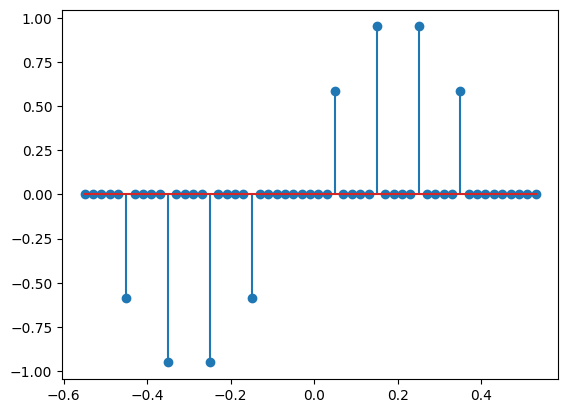

In [3]:
upsampling_factor = 5 # increase the sampling frequency by 5
Fs_p = upsampling_factor*Fs    
y_p = np.zeros(int(len(x)*Fs_p/Fs))
y_p[::int(Fs_p/Fs)] = y
x_p = np.arange(-len(y_p)/2, len(y_p)/2)/Fs_p # one period of the signal
plt.stem(x_p, y_p)

Now let's apply interpolation kernels using an isoceles triangle:

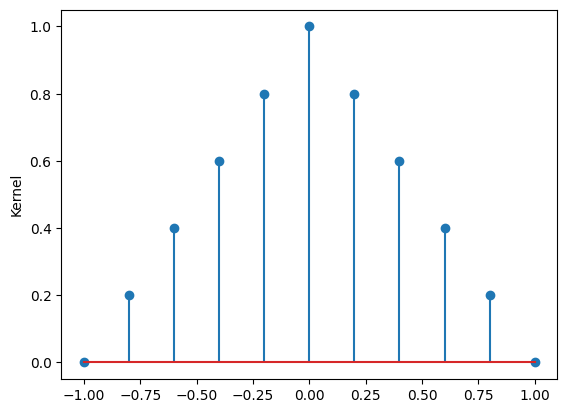

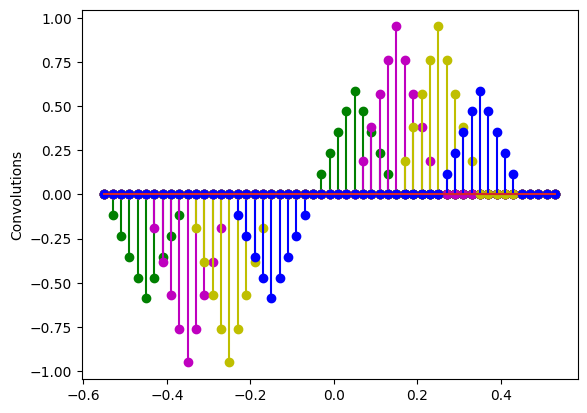

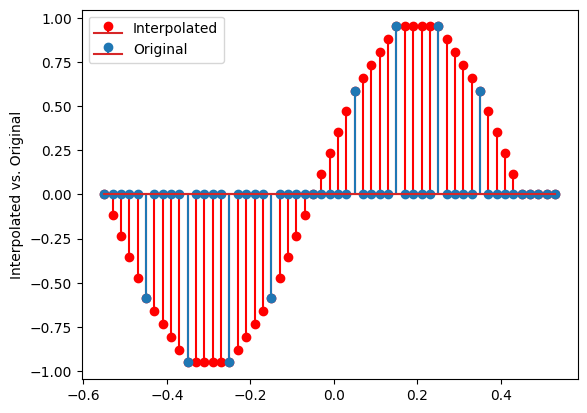

In [4]:
colors = ['r', 'g', 'm', 'y', 'b']

def isoceles_triangle(x:int) -> list:
    return 1.0-np.abs(x) if np.abs(x)<=1 else 0

def isoceles_triangle_kernel(a:int, b:int, size:int) -> (list, list):
    # ignore a, b
    x = np.linspace(-1, 1, size)
    return x, [isoceles_triangle(x_i) for x_i in x]

def apply_interpolation_kernel(
    x:list, y:list, x_p:list, y_p:list, kernel_function, kernel_lengths:list, 
    plot_convolutions:bool) -> (list, list):
    
    y_pp = np.zeros(len(y_p))

    # plot the convolutions, individually
    if plot_convolutions:
        plt.figure()
        
    for n in range(1, len(y)-1):
        _, kernel = kernel_function(y[n-1]-y[n], y[n+1]-y[n], kernel_lengths[n])
        zeros = np.zeros(len(y_p))
        zeros[n*upsampling_factor] = y[n]
        convolution = np.convolve(zeros, kernel, 'same')
        y_pp += convolution
        
        if plot_convolutions:
            plt.stem(x_p, convolution, colors[n%len(colors)], markerfmt=f'{colors[n%len(colors)]}o')
            plt.ylabel('Convolutions')
            
    return x_p, y_pp
            
def compute_and_plot_interpolation(
    x:list, y:list, x_p:list, y_p:list, kernel_function, kernel_lengths:list, 
    plot_convolutions:bool) -> (list, list):
    
    kernel_size = [2*upsampling_factor+1]*len(y)
    x_p, y_pp = apply_interpolation_kernel(x, y, x_p, y_p, kernel_function, kernel_size, plot_convolutions)
    
    # plot the result (the sum of all convolutions)
    plt.figure()
    plt.stem(x_p, y_pp,'r-')
    plt.stem(x_p, y_p)
    plt.legend(['Interpolated', 'Original'])
    plt.ylabel('Interpolated vs. Original')

# plot the kernel and the result of the interpolation
kernel_size = 2*upsampling_factor+1
kernel_x, kernel_y = isoceles_triangle_kernel(0, 0, kernel_size)
plt.stem(kernel_x, kernel_y)
plt.ylabel('Kernel')
compute_and_plot_interpolation(x, y, x_p, y_p, isoceles_triangle_kernel, [kernel_size]*len(y), 
    plot_convolutions=True)

As you can see, the interpolating signal is the resulting of "connecting" the dots with a straight line. Also, when specifying other kernel, you can obtain a smother approximation:

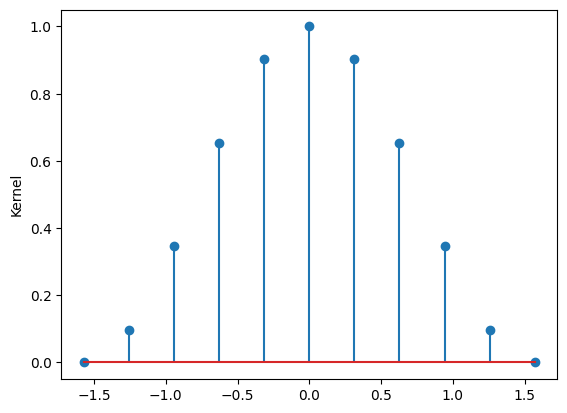

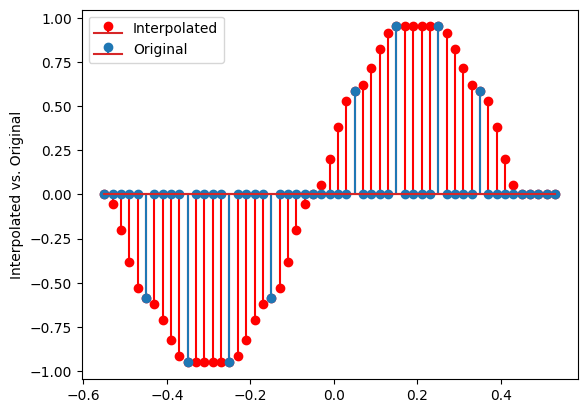

In [5]:
def hanning_kernel(a: int, b:int, size:int) -> (list, list):
    x = np.linspace(-np.pi/2, np.pi/2, size)
    return x, np.hanning(size)

# plot the kernel and the result of the interpolation
kernel_size = 2*upsampling_factor+1
kernel_x, kernel_y = hanning_kernel(0, 0, kernel_size)
plt.stem(kernel_x, kernel_y)
plt.ylabel('Kernel')
compute_and_plot_interpolation(x, y, x_p, y_p, hanning_kernel, [kernel_size]*len(y), 
    plot_convolutions=False)

# Interpolation using a non-fixed sampling rate 

To apply the same method to the LIBOR rate we need to modify equation 2 a little bit because the LIBOR is not sampled at an uniform sampling rate ($T$ is not the same for all samples); for instance, the distance between six to three months is not the same than the distance between six to twelve). This can be solved using asymmetric interpolation kernels (scalene triangles). First, we need to upsample the signal as we did in the example above.

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

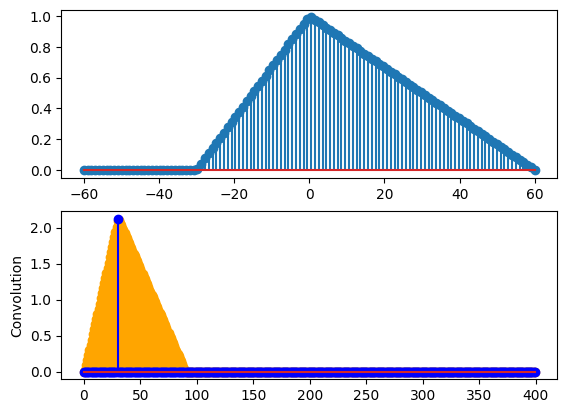

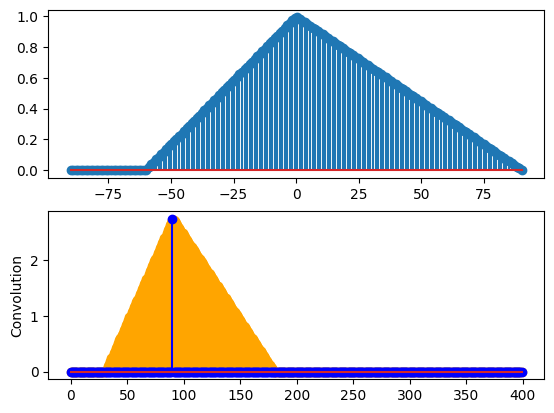

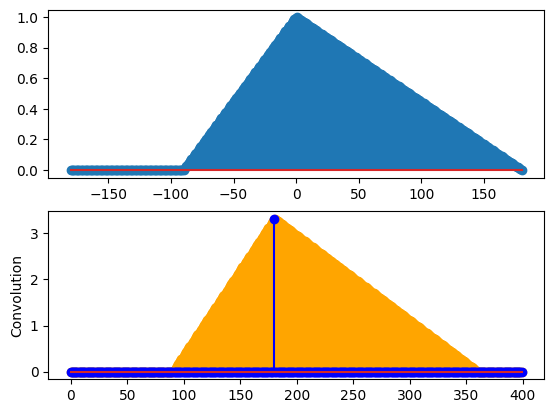

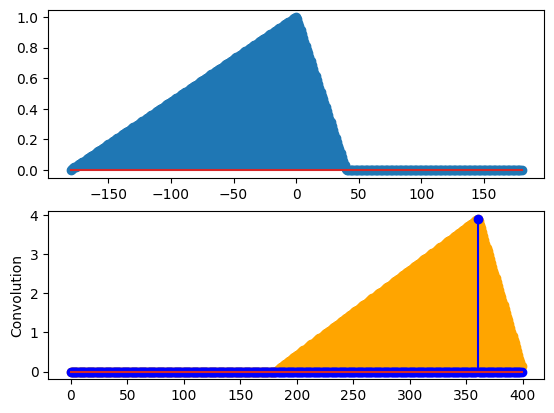

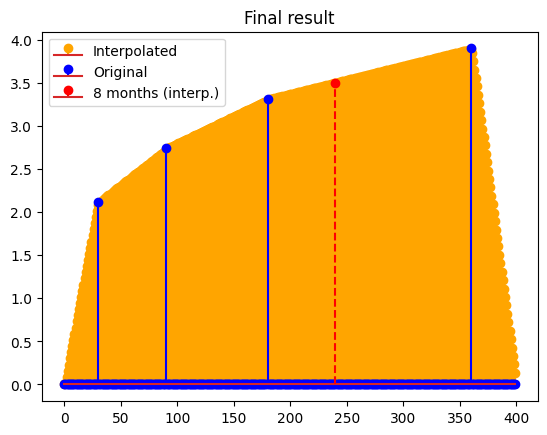

In [6]:
def scalene_triangle_kernel(a: int, b: int, size: int) -> (list, list):
    new_size = size+max(a,b)-min(a,b)
    x = np.linspace(-max(a,b), max(a,b), new_size)
    y = np.zeros(new_size)
    for n in range(new_size):
        y[n] = isoceles_triangle(x[n]/a) if x[n]<=0 else isoceles_triangle(x[n]/b)
    return x, y

# re-sampled Libor scales at one month, then apply convolutions...
plt.figure()
y_p = np.zeros(400)
y_p[30] = 2.12029
y_p[90] = 2.73757
y_p[180] = 3.31129
y_p[360] = 3.89643
x_p = np.arange(len(y_p))

# --------------------------
# Main
# --------------------------
plt.figure()
y_pp = np.zeros(len(y_p))
x = [0, 30, 90, 180, 360, 400]
y = [0, 2.12029, 2.73757, 3.31129, 3.89643, 0]

for n in range(1, len(x)-1):
    
    zeros = np.zeros(len(y_p))
    zeros[x[n]] = y_p[x[n]]
    
    kernel_x, kernel_y = scalene_triangle_kernel(
        np.abs(x[n-1]-x[n]), 
        np.abs(x[n+1]-x[n]), 
        np.abs(x[n+1]-x[n-1])
    )
    
    plt.figure()
    plt.subplot(211)
    plt.stem(kernel_x, kernel_y)
    plt.subplot(212)
    convolution = np.convolve(zeros, kernel_y, 'same')
    y_pp += convolution
    plt.stem(x_p, convolution, 'orange')
    plt.stem(x_p, zeros, 'blue')
    plt.ylabel(f'Convolution')

plt.figure()
plt.title('Final result')
plt.stem(x_p, y_pp, 'orange')
plt.stem(x_p, y_p, 'blue')
plt.stem(8*30, y_pp[8*30], 'r--')
plt.legend(['Interpolated', 'Original', '8 months (interp.)'])

Where, the rounded value at eight months is 3.5, same as the one computed manually in the sections above.

In [7]:
print(f'Eight months LIBOR rate: {y_pp[8*30]}.')

Eight months LIBOR rate: 3.494396490250696.


# Conclusion

Interpolation is a technique that allows approximation of unknown values between samples on a signal sampled at a regular interval. It can be either performed manually or by summing convolutions of the samples with an interpolation kernel. The shape of the kernel determines the types of interpolation (linear, polynomic, etc...). For signals sampled at an irregular period we can apply zero-padding, to upsample the signal, and then custom asymmetric kernels. We confirmed the findings using the LIBOR rate, a signal used to calculate loans in four maturity levels (months).


# References:

1. Banco Central de Costa Rica. **Tasa libor 1 mes**. URL: https://gee.bccr.fi.cr/indicadoreseconomicos/Cuadros/frmVerCatCuadro.aspx?idioma=1&CodCuadro=%20334 (last consulted on 04/11/15).

2. P. Prandoni, M. Vertterli. **Signal processing for communications.** EPFL press 2008.

3. Wikipedia contributors. (2019, August 1). Libor scandal. In Wikipedia, The Free Encyclopedia. Retrieved 23:50, August 15, 2019, from https://en.wikipedia.org/w/index.php?title=Libor_scandal&oldid=908807968.

4. Miguel Elizondo. El LIBOR dejará de existir en el 2021. La República.net, Impacto legal. Monday, July 31-th, 2017. URL: https://www.larepublica.net/noticia/el-libor-dejara-de-existir-en-el-2021.

5. Linear interpolation example. International Swaps and Derivatives Association. URL: https://www.isda.org/a/7KiDE/linear-interpolation-example-1-10.pdf.

6. LIBOR. (2024, 10 de noviembre). Wikipedia, La enciclopedia libre. Fecha de consulta: 21:14, noviembre 10, 2024 desde https://es.wikipedia.org/w/index.php?title=LIBOR&oldid=163512053.

# Notes
1. The images were taken from [here](https://i.dailymail.co.uk/i/pix/2012/07/12/article-2172377-140736A7000005DC-647_634x422.jpg) and [here](https://c8.alamy.com/comp/CTX670/libor-scandal-headlines-the-financial-times-newspaper-london-august-CTX670.jpg)

# Appendix 

## Consuming the LIBOR rate from the BCCR SOAP web service 

Here is the code to get all Libor rates [1]:

Last 1 month(s) Libor rates: [2.156, 2.12029]
Last 3 month(s) Libor rates: [2.74029, 2.73757]
Last 6 month(s) Libor rates: [3.38129, 3.31129]
Last 12 month(s) Libor rates: [3.97829, 3.89643]


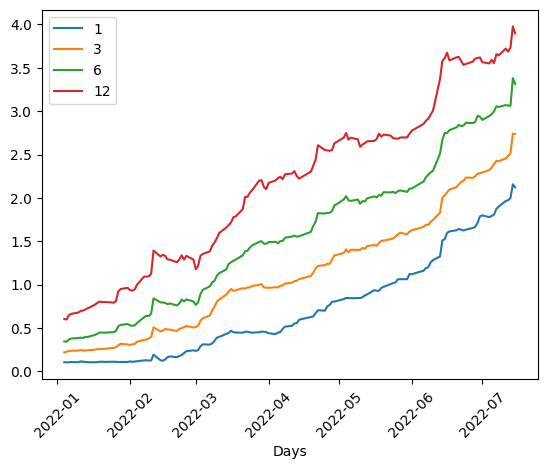

In [8]:
import matplotlib.pylab as plt
from zeep import Client # SOAP client
import xml.etree.ElementTree as ET # read XMLs
import datetime
import os
import dateutil.parser

def plot_libor_rate(libor_rate_code:int, fecha_inicio:str, fecha_final:str) -> (list, list):
    
    dicc = client.service.ObtenerIndicadoresEconomicosXML(
        Indicador=libor_rate_code, 
        FechaInicio=fecha_inicio,
        FechaFinal=fecha_final,
        Nombre = 'juanfonsecasolis.github.io',
        SubNiveles = 'N',
        CorreoElectronico = os.environ['EMAIL'],
        Token = os.environ['BCCR_TOKEN']
    )
    
    # extract the XML that comes embedded in the dictionary data structure
    raiz = ET.fromstring(dicc)
    
    # build the signal
    x = []
    y = []
    for hijo in raiz:
        if 2<len(hijo):    # weekends have no rate
            x.append(dateutil.parser.isoparse(hijo[1].text))
            y.append(float(hijo[2].text))
        
    # plot
    return x, y

'''
Main
'''
if __name__ == '__main__':
    client = Client('https://gee.bccr.fi.cr/Indicadores/Suscripciones/WS/wsindicadoreseconomicos.asmx?WSDL')

    # Libor rates (https://gee.bccr.fi.cr/indicadoreseconomicos/Documentos/DocumentosMetodologiasNotasTecnicas/Webservices_de_indicadores_economicos.pdf)
    libor_rate_scales = {
        '1': 349,
        '3': 350,
        '6': 351,
        '12': 352,
    }

    # find the Libor rate since a date in the past
    libor_rates = {}

    plt.figure()
    for libor_rate_scale in libor_rate_scales.keys():
        (dates, rates) = plot_libor_rate( 
            libor_rate_scales[libor_rate_scale],
            fecha_inicio = '01/01/2022',
            fecha_final = '16/07/2022'
        )
        print(f'Last {libor_rate_scale} month(s) Libor rates: {rates[-2:]}')
        libor_rate_scales[libor_rate_scale] = {'dates': dates, 'rates': rates}
        plt.plot(dates, rates)

    plt.legend(libor_rate_scales.keys())
    plt.xticks(rotation = 45)
    plt.xlabel('Days')
    plt.show()

---
<a rel="license" href="http://creativecommons.org/licenses/by-nd/4.0/"><img alt="licencia Creative Commons" style="border-width:0" src="../img/80x15_by-nd.png" /></a><p style="text-align: center;"> This work is under a <a rel="license" href="http://creativecommons.org/licenses/by-nd/4.0/">Creative Commons Atribución 4.0 Internacional license</a>. The website <a href="https://juanfonsecasolis.github.io/">juanfonsecasolis.github.io</a> It is a Costa Rican blog dedicated to independent research on issues related to digital signal processing. To reuse this article and cite the source you can use Bibtex:</p>
```
@online{Fonseca2015,
  author = {Juan M. Fonseca-Solís},
  title = { Interpolating the Libor rate },
  year = 2015,
  url = {https://juanfonsecasolis.github.io/blog/JFonseca.interpolacion.html},
  urldate = {}
}
```

<!-- DISQUIS -->

<div id="disqus_thread"></div>
<script>

/**
*  RECOMMENDED CONFIGURATION VARIABLES: EDIT AND UNCOMMENT THE SECTION BELOW TO INSERT DYNAMIC VALUES FROM YOUR PLATFORM OR CMS.
*  LEARN WHY DEFINING THESE VARIABLES IS IMPORTANT: https://disqus.com/admin/universalcode/#configuration-variables
*/
var disqus_config = function () {
this.page.url = 'https://juanfonsecasolis.github.io/blog/JFonseca.interpolacionBL.html';  // Replace PAGE_URL with your page's canonical URL variable
this.page.identifier = 1; // Replace PAGE_IDENTIFIER with your page's unique identifier variable
};

(function() { // DON'T EDIT BELOW THIS LINE
var d = document, s = d.createElement('script');
s.src = 'https://https-juanfonsecasolis-github-io.disqus.com/embed.js';
s.setAttribute('data-timestamp', +new Date());
(d.head || d.body).appendChild(s);
})();
</script>
<noscript>Please enable JavaScript to view the <a href="https://disqus.com/?ref_noscript">comments powered by Disqus.</a></noscript>
<script id="dsq-count-scr" src="https://https-juanfonsecasolis-github-io.disqus.com/count.js" async></script>